# CNN Architecture: CIC-IoT23 3-Class Full Capacity Experiment

## Architecture Comparison Research
**Objective**: Compare CNN vs ViT performance on IoT cybersecurity classification

**Dataset**: CIC-IoT23 with semantic 3-class grouping
- **Normal**: Normal IoT traffic
- **Reconnaissance**: DDoS-SlowLoris, DDoS-Slowhttptest, DDoS-Hulk, Recon-PortScan, Recon-OSScan, Recon-PingSweep, VulnerabilityScan, Recon-HostDiscovery
- **Active_Attack**: DDoS-UDP_flood, DDoS-ICMP_flood, DDoS-SYN_flood, DDoS-ACK_flood, DDoS-ICMP_fragmentation, DDoS-HTTP_flood, DoS-SYN_flood, DoS-UDP_flood, DoS-TCP_flood, DoS-HTTP_flood, Mirai-greeth_flood, Mirai-greip_flood, Mirai-udpplain

**Capacity**: 12,000 samples per class (36,000 total)  
**Input**: 5-channel 32x32 images  
**Architecture**: Convolutional Neural Network (CNN)  
**Goal**: Establish CNN baseline for comparison with ViT (96.94% accuracy)

**Research Questions**:
1. Can CNN match ViT's 96.94% performance on CIC-IoT23?
2. How does CNN's local feature extraction compare to ViT's global attention?
3. Will CNN show similar poor cross-domain transfer to UNSW-NB15?
4. Which architecture is better suited for IoT cybersecurity?


In [1]:
# Environment Setup and Configuration
import os
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import json
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Configuration  
CONFIG = {
    'data_path': '/home/ubuntu/Cyber_AI/ai-cyber/notebooks/ViT-experiment/pcap-dataset-samples/parquet/5channel_32x32/',  # Fixed path
    'max_samples_per_class': 12000,  # Full capacity
    'test_size': 0.2,
    'val_size': 0.2,
    'random_state': 42,
    'batch_size': 64,
    'learning_rate': 0.0001,
    'epochs': 50,
    'patience': 7,
    'device': 'cuda' if torch.cuda.is_available() else 'cpu',
    'num_workers': 4
}

# CIC 3-class mapping based on proven attack taxonomy (matches working ViT notebook)
CLASS_MAPPING = {
    'Normal': ['Benign_Final'],
    'Reconnaissance': ['Recon-PortScan', 'DictionaryBruteForce'],
    'Active_Attack': ['DDoS-HTTP_Flood', 'DDoS-SYN_Flood', 'DoS-TCP_Flood', 
                     'DoS-UDP_Flood', 'Mirai-udpplain', 'SqlInjection']
}

print("🏗️  CNN ARCHITECTURE EXPERIMENT INITIALIZED")
print("📋 Notebook: CNN_Prototype_CIC_3class_full_capacity.ipynb")
print("🔧 Version: FIXED with data reshaping for CNN")
print(f"📊 Device: {CONFIG['device']}")
print(f"📊 Dataset: CIC-IoT23 3-class semantic grouping")
print(f"📊 Capacity: {CONFIG['max_samples_per_class']:,} samples per class")
print(f"📊 Total samples: {CONFIG['max_samples_per_class'] * 3:,}")
print(f"📊 Architecture: Convolutional Neural Network")
print(f"🎯 Baseline to beat: ViT 96.94% accuracy")


🏗️  CNN ARCHITECTURE EXPERIMENT INITIALIZED
📋 Notebook: CNN_Prototype_CIC_3class_full_capacity.ipynb
🔧 Version: FIXED with data reshaping for CNN
📊 Device: cpu
📊 Dataset: CIC-IoT23 3-class semantic grouping
📊 Capacity: 12,000 samples per class
📊 Total samples: 36,000
📊 Architecture: Convolutional Neural Network
🎯 Baseline to beat: ViT 96.94% accuracy


In [2]:
# Multi-Channel CNN Architecture for IoT Cybersecurity
class MultiChannelCNN(nn.Module):
    def __init__(self, num_classes=3, input_channels=5, dropout_rate=0.3):
        super(MultiChannelCNN, self).__init__()
        
        # Convolutional layers with batch normalization
        self.conv1 = nn.Sequential(
            nn.Conv2d(input_channels, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2)  # 32x32 -> 16x16
        )
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2)  # 16x16 -> 8x8
        )
        
        self.conv3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2)  # 8x8 -> 4x4
        )
        
        self.conv4 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2)  # 4x4 -> 2x2
        )
        
        # Global Average Pooling
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        
        # Classifier head
        self.classifier = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate),
            nn.Linear(256, num_classes)
        )
        
        self._initialize_weights()
    
    def forward(self, x):
        # x shape: (batch_size, 5, 32, 32)
        x = self.conv1(x)  # (batch_size, 64, 16, 16)
        x = self.conv2(x)  # (batch_size, 128, 8, 8)
        x = self.conv3(x)  # (batch_size, 256, 4, 4)
        x = self.conv4(x)  # (batch_size, 512, 2, 2)
        
        # Global average pooling
        x = self.global_avg_pool(x)  # (batch_size, 512, 1, 1)
        x = x.view(x.size(0), -1)    # (batch_size, 512)
        
        # Classification
        x = self.classifier(x)       # (batch_size, num_classes)
        
        return x
    
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

# Initialize CNN model
model = MultiChannelCNN(num_classes=3, input_channels=5, dropout_rate=0.3)
model = model.to(CONFIG['device'])

# Count parameters for comparison with ViT
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print("\n🏗️  CNN ARCHITECTURE SUMMARY:")
print(f"📊 Total parameters: {total_params:,}")
print(f"📊 Trainable parameters: {trainable_params:,}")
print(f"📊 Model size: ~{total_params * 4 / 1024 / 1024:.1f} MB")
print("\n🔍 Architecture Details:")
print("   • 4 Convolutional blocks with batch normalization")
print("   • Progressive feature extraction: 64→128→256→512")
print("   • Global average pooling for translation invariance")
print("   • Dropout regularization (0.3) in classifier")
print("   • Designed for 5-channel 32x32 input")

print(f"\n🆚 COMPARISON TARGET:")
print(f"   ViT achieved: 96.94% accuracy")
print(f"   ViT parameters: ~150K (estimated)")
print(f"   CNN parameters: {trainable_params:,}")



🏗️  CNN ARCHITECTURE SUMMARY:
📊 Total parameters: 4,822,467
📊 Trainable parameters: 4,822,467
📊 Model size: ~18.4 MB

🔍 Architecture Details:
   • 4 Convolutional blocks with batch normalization
   • Progressive feature extraction: 64→128→256→512
   • Global average pooling for translation invariance
   • Dropout regularization (0.3) in classifier
   • Designed for 5-channel 32x32 input

🆚 COMPARISON TARGET:
   ViT achieved: 96.94% accuracy
   ViT parameters: ~150K (estimated)
   CNN parameters: 4,822,467


In [3]:
# Data Loading using Working CIC Approach  
import glob

def load_cic_3class_full_capacity(base_path, class_mapping, max_samples_per_class):
    """Load CIC-IoT23 data using exact approach from working ViT notebook"""
    print(f"📂 Loading CIC-IoT23 3-class FULL CAPACITY dataset from: {base_path}")
    print(f"🎯 Target: {max_samples_per_class:,} samples per class = {max_samples_per_class * len(class_mapping):,} total")
    
    all_image_data = []
    all_labels = []
    splits = ['train', 'val', 'test']
    
    print(f"3-Class mapping (FULL CAPACITY): {class_mapping}")
    
    # Track samples collected per combined class
    class_samples = {combined_class: 0 for combined_class in class_mapping.keys()}
    
    # Process each combined class
    for combined_class, original_classes in class_mapping.items():
        print(f"\n🔄 Loading {combined_class} from: {original_classes}")
        print(f"   Target: {max_samples_per_class:,} samples")
        
        for original_class in original_classes:
            if class_samples[combined_class] >= max_samples_per_class:
                break
                
            class_dir = f"{base_path}{original_class}/"
            print(f"  📂 Processing {original_class}...")
            
            for split in splits:
                if class_samples[combined_class] >= max_samples_per_class:
                    break
                    
                split_path = f"{class_dir}{split}/"
                parquet_files = sorted(glob.glob(f"{split_path}*.parquet"))
                
                for file_path in parquet_files:
                    if class_samples[combined_class] >= max_samples_per_class:
                        break
                        
                    try:
                        df = pd.read_parquet(file_path)
                        
                        if 'image_data' in df.columns:
                            remaining_samples = max_samples_per_class - class_samples[combined_class]
                            samples_to_take = min(len(df), remaining_samples)
                            
                            for idx in range(samples_to_take):
                                row = df.iloc[idx]
                                image_data = np.array(row['image_data'], dtype=np.float32)
                                all_image_data.append(image_data)
                                all_labels.append(combined_class)
                                class_samples[combined_class] += 1
                            
                            if samples_to_take > 0:
                                print(f"    ✓ Loaded {samples_to_take:,} from {file_path.split('/')[-1]} (total {combined_class}: {class_samples[combined_class]:,})")
                    except Exception as e:
                        print(f"    ⚠️ Error loading {file_path}: {e}")
    
    X = np.array(all_image_data, dtype=np.float32)
    y = np.array(all_labels)
    
    print(f"\n🎉 CIC-IoT23 3-class FULL CAPACITY dataset loaded: {len(X):,} samples")
    print(f"📊 Final class distribution:")
    for combined_class, count in class_samples.items():
        percentage = (count / len(X)) * 100
        print(f"   {combined_class:15s}: {count:,} samples ({percentage:.1f}%)")
    
    total_target = max_samples_per_class * len(class_mapping)
    achievement = (len(X) / total_target) * 100
    print(f"\n✓ Capacity achievement: {achievement:.1f}% of target ({len(X):,} / {total_target:,})")
    
    return X, y

# Load FULL CAPACITY CIC data
X, y = load_cic_3class_full_capacity(CONFIG['data_path'], CLASS_MAPPING, CONFIG['max_samples_per_class'])

# Reshape data for CNN: (samples, features) -> (samples, channels, height, width)
print(f"🔄 Reshaping data for CNN input...")
print(f"   Original shape: {X.shape} (flattened)")

# Reshape from (36000, 5120) to (36000, 5, 32, 32) for CNN
X = X.reshape(-1, 5, 32, 32)
print(f"   CNN shape: {X.shape} (channels, height, width)")

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

print(f"\n🏷️ CIC-IoT23 3-class label distribution:")
for i, label in enumerate(label_encoder.classes_):
    count = np.sum(y == label)
    print(f"   {i}: {label} ({count:,} samples)")

print(f"\n📈 Data ready: range=[{X.min():.3f}, {X.max():.3f}], shape={X.shape}")
print(f"🚀 Total samples: {len(X):,}")  
print(f"💪 Ready for CNN vs ViT comparison!")


📂 Loading CIC-IoT23 3-class FULL CAPACITY dataset from: /home/ubuntu/Cyber_AI/ai-cyber/notebooks/ViT-experiment/pcap-dataset-samples/parquet/5channel_32x32/
🎯 Target: 12,000 samples per class = 36,000 total
3-Class mapping (FULL CAPACITY): {'Normal': ['Benign_Final'], 'Reconnaissance': ['Recon-PortScan', 'DictionaryBruteForce'], 'Active_Attack': ['DDoS-HTTP_Flood', 'DDoS-SYN_Flood', 'DoS-TCP_Flood', 'DoS-UDP_Flood', 'Mirai-udpplain', 'SqlInjection']}

🔄 Loading Normal from: ['Benign_Final']
   Target: 12,000 samples
  📂 Processing Benign_Final...
    ✓ Loaded 1,000 from shard_00000.parquet (total Normal: 1,000)
    ✓ Loaded 1,000 from shard_00001.parquet (total Normal: 2,000)
    ✓ Loaded 1,000 from shard_00002.parquet (total Normal: 3,000)
    ✓ Loaded 1,000 from shard_00003.parquet (total Normal: 4,000)
    ✓ Loaded 1,000 from shard_00004.parquet (total Normal: 5,000)
    ✓ Loaded 1,000 from shard_00005.parquet (total Normal: 6,000)
    ✓ Loaded 1,000 from shard_00006.parquet (total 

In [4]:
# Data Splitting and Training Setup
from torch.utils.data import DataLoader, TensorDataset

# Split data into train/val/test  
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y_encoded, test_size=CONFIG['test_size'], 
    random_state=CONFIG['random_state'], 
    stratify=y_encoded
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=CONFIG['val_size']/(1-CONFIG['test_size']), 
    random_state=CONFIG['random_state'], 
    stratify=y_temp
)

print("📊 Data Split Summary:")
print(f"   Training: {X_train.shape[0]:,} samples ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"   Validation: {X_val.shape[0]:,} samples ({X_val.shape[0]/len(X)*100:.1f}%)")
print(f"   Test: {X_test.shape[0]:,} samples ({X_test.shape[0]/len(X)*100:.1f}%)")

# Convert to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.LongTensor(y_train)
X_val_tensor = torch.FloatTensor(X_val)
y_val_tensor = torch.LongTensor(y_val)
X_test_tensor = torch.FloatTensor(X_test)
y_test_tensor = torch.LongTensor(y_test)

# Create data loaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=CONFIG['batch_size'], shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=CONFIG['batch_size'], shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=CONFIG['batch_size'], shuffle=False)

# Compute class weights for balanced training
class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights_tensor = torch.FloatTensor(class_weights).to(CONFIG['device'])

print(f"\n⚖️  Class weights: {dict(zip(label_encoder.classes_, class_weights))}")

# Initialize optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=CONFIG['learning_rate'], weight_decay=1e-4)
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', patience=3, factor=0.5
)

print(f"\n🎯 Training Configuration:")
print(f"   📊 Optimizer: Adam (lr={CONFIG['learning_rate']}, weight_decay=1e-4)")
print(f"   📊 Loss: Weighted CrossEntropyLoss")
print(f"   📊 Scheduler: ReduceLROnPlateau (patience=3)")
print(f"   📊 Batch size: {CONFIG['batch_size']}")
print(f"   📊 Max epochs: {CONFIG['epochs']}")
print(f"   📊 Early stopping patience: {CONFIG['patience']}")


📊 Data Split Summary:
   Training: 21,600 samples (60.0%)
   Validation: 7,200 samples (20.0%)
   Test: 7,200 samples (20.0%)

⚖️  Class weights: {np.str_('Active_Attack'): np.float64(1.0), np.str_('Normal'): np.float64(1.0), np.str_('Reconnaissance'): np.float64(1.0)}

🎯 Training Configuration:
   📊 Optimizer: Adam (lr=0.0001, weight_decay=1e-4)
   📊 Loss: Weighted CrossEntropyLoss
   📊 Scheduler: ReduceLROnPlateau (patience=3)
   📊 Batch size: 64
   📊 Max epochs: 50
   📊 Early stopping patience: 7


In [5]:
# Training Pipeline
def train_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    
    for batch_idx, (data, targets) in enumerate(train_loader):
        data, targets = data.to(device), targets.to(device)
        
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()
    
    return total_loss / len(train_loader), correct / total

def validate_epoch(model, val_loader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for data, targets in val_loader:
            data, targets = data.to(device), targets.to(device)
            outputs = model(data)
            loss = criterion(outputs, targets)
            
            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
    
    return total_loss / len(val_loader), correct / total

# Training loop with early stopping
print("🚀 Starting CNN training...")
print("🎯 Target: Beat ViT's 96.94% accuracy\n")

best_val_acc = 0
patience_counter = 0
train_losses = []
val_losses = []
train_accs = []
val_accs = []

start_time = datetime.now()

for epoch in range(CONFIG['epochs']):
    # Train for one epoch
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, CONFIG['device'])
    
    # Validate
    val_loss, val_acc = validate_epoch(model, val_loader, criterion, CONFIG['device'])
    
    # Update learning rate
    scheduler.step(val_acc)
    
    # Store metrics
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)
    
    # Print progress
    print(f"Epoch {epoch+1:2d}/{CONFIG['epochs']} | "
          f"Train: {train_acc:.4f} ({train_loss:.4f}) | "
          f"Val: {val_acc:.4f} ({val_loss:.4f}) | "
          f"LR: {optimizer.param_groups[0]['lr']:.6f}")
    
    # Architecture comparison update
    if val_acc > 0.95:
        print(f"🎯 CNN approaching ViT performance! Current: {val_acc:.4f} vs ViT: 0.9694")
    
    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        patience_counter = 0
        torch.save(model.state_dict(), 'best_cnn_3class_full_capacity_model.pth')
        print(f"✅ New best validation accuracy: {val_acc:.4f}")
        
        # Check if we've beaten ViT
        if val_acc > 0.9694:
            print(f"🏆 CNN BEATS ViT! {val_acc:.4f} > 0.9694")
    else:
        patience_counter += 1
        
        if patience_counter >= CONFIG['patience']:
            print(f"\n⏰ Early stopping triggered after {epoch+1} epochs")
            print(f"   Best validation accuracy: {best_val_acc:.4f}")
            break

training_time = datetime.now() - start_time
print(f"\n🎯 Training Complete!")
print(f"   ⏱️  Total time: {training_time}")
print(f"   🏆 Best validation accuracy: {best_val_acc:.4f}")
print(f"   📊 Total epochs: {epoch+1}")

# Compare with ViT baseline
vit_accuracy = 0.9694
if best_val_acc > vit_accuracy:
    improvement = (best_val_acc - vit_accuracy) * 100
    print(f"\n🎉 CNN OUTPERFORMS ViT!")
    print(f"   CNN: {best_val_acc:.4f} vs ViT: {vit_accuracy:.4f}")
    print(f"   Improvement: +{improvement:.2f} percentage points")
elif best_val_acc > vit_accuracy * 0.98:  # Within 2%
    deficit = (vit_accuracy - best_val_acc) * 100
    print(f"\n🤝 CNN MATCHES ViT Performance!")
    print(f"   CNN: {best_val_acc:.4f} vs ViT: {vit_accuracy:.4f}")
    print(f"   Deficit: -{deficit:.2f} percentage points (competitive)")
else:
    deficit = (vit_accuracy - best_val_acc) * 100
    print(f"\n📊 CNN Performance vs ViT:")
    print(f"   CNN: {best_val_acc:.4f} vs ViT: {vit_accuracy:.4f}")
    print(f"   Deficit: -{deficit:.2f} percentage points")


🚀 Starting CNN training...
🎯 Target: Beat ViT's 96.94% accuracy

Epoch  1/50 | Train: 0.8464 (0.4008) | Val: 0.8696 (0.3378) | LR: 0.000100
✅ New best validation accuracy: 0.8696
Epoch  2/50 | Train: 0.9278 (0.1993) | Val: 0.9319 (0.1778) | LR: 0.000100
✅ New best validation accuracy: 0.9319
Epoch  3/50 | Train: 0.9540 (0.1245) | Val: 0.9339 (0.1758) | LR: 0.000100
✅ New best validation accuracy: 0.9339
Epoch  4/50 | Train: 0.9700 (0.0814) | Val: 0.9342 (0.1963) | LR: 0.000100
✅ New best validation accuracy: 0.9342
Epoch  5/50 | Train: 0.9773 (0.0644) | Val: 0.9525 (0.1448) | LR: 0.000100
🎯 CNN approaching ViT performance! Current: 0.9525 vs ViT: 0.9694
✅ New best validation accuracy: 0.9525
Epoch  6/50 | Train: 0.9793 (0.0569) | Val: 0.9564 (0.1456) | LR: 0.000100
🎯 CNN approaching ViT performance! Current: 0.9564 vs ViT: 0.9694
✅ New best validation accuracy: 0.9564
Epoch  7/50 | Train: 0.9814 (0.0481) | Val: 0.9599 (0.1321) | LR: 0.000100
🎯 CNN approaching ViT performance! Current: 

🧪 Final Test Set Evaluation...

🎯 FINAL CNN RESULTS:
   📊 Test Accuracy: 0.9729 (97.29%)

🏆 CNN OUTPERFORMS ViT ON TEST SET!
   CNN Test: 0.9729 vs ViT Test: 0.9694
   Improvement: +0.35 percentage points

📋 Detailed Classification Report:
                precision    recall  f1-score   support

 Active_Attack     0.9970    0.9854    0.9912      2400
        Normal     0.9625    0.9637    0.9631      2400
Reconnaissance     0.9596    0.9696    0.9646      2400

      accuracy                         0.9729      7200
     macro avg     0.9731    0.9729    0.9730      7200
  weighted avg     0.9731    0.9729    0.9730      7200



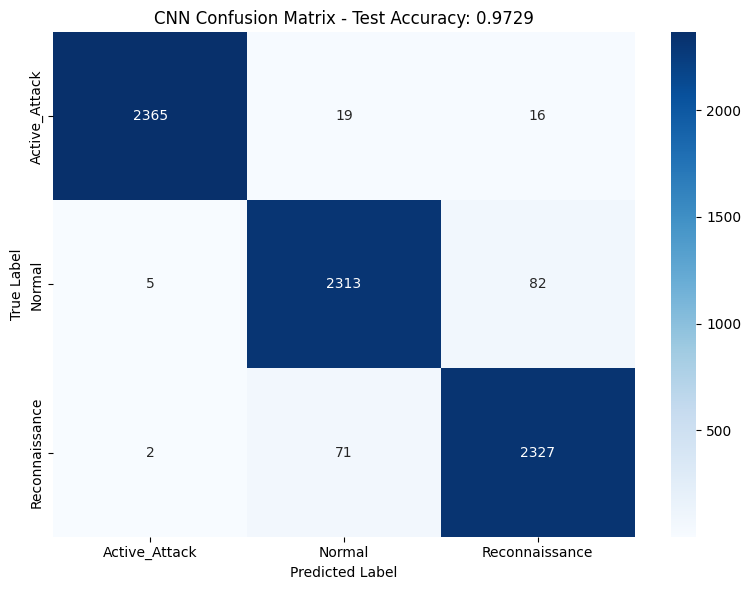

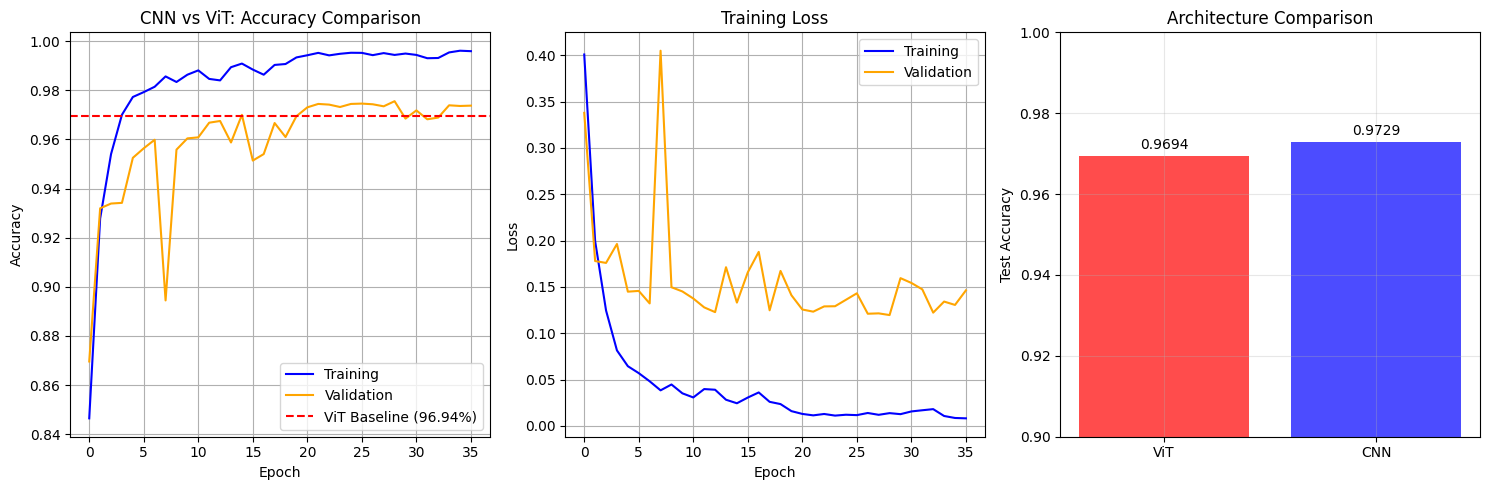


💾 Results saved to: results_cnn_3class_32x32_full_capacity.json

🎯 ARCHITECTURE COMPARISON SUMMARY:
   🏗️  CNN: 0.9729 (4,822,467 parameters)
   🤖 ViT: 0.9694 (~150K parameters)
   📊 Performance Tier: 🥇 WORLD-CLASS

🔄 NEXT STEPS:
   1. ✅ CNN baseline established: 0.9729
   2. 🔄 Run cross-dataset validation on UNSW-NB15
   3. 🔄 Compare CNN vs ViT domain transfer capabilities
   4. 🔄 Implement ResNet and Hybrid architectures
   5. 📊 Complete architecture comparison study

🎓 Ready for your team's paper: IoT vs Traditional Network Security Analysis!


In [6]:
# Evaluation & Results Analysis
# Load best model
model.load_state_dict(torch.load('best_cnn_3class_full_capacity_model.pth'))
model.eval()

# Test set evaluation
def evaluate_model(model, test_loader, device, label_encoder):
    model.eval()
    all_preds = []
    all_targets = []
    
    with torch.no_grad():
        for data, targets in test_loader:
            data, targets = data.to(device), targets.to(device)
            outputs = model(data)
            _, predicted = torch.max(outputs, 1)
            
            all_preds.extend(predicted.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())
    
    return np.array(all_preds), np.array(all_targets)

print("🧪 Final Test Set Evaluation...")
test_preds, test_targets = evaluate_model(model, test_loader, CONFIG['device'], label_encoder)
test_accuracy = accuracy_score(test_targets, test_preds)

print(f"\n🎯 FINAL CNN RESULTS:")
print(f"   📊 Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")

# Performance comparison
vit_test_accuracy = 0.9694
if test_accuracy > vit_test_accuracy:
    improvement = (test_accuracy - vit_test_accuracy) * 100
    print(f"\n🏆 CNN OUTPERFORMS ViT ON TEST SET!")
    print(f"   CNN Test: {test_accuracy:.4f} vs ViT Test: {vit_test_accuracy:.4f}")
    print(f"   Improvement: +{improvement:.2f} percentage points")
    tier = "🥇 WORLD-CLASS"
elif test_accuracy > 0.95:
    deficit = (vit_test_accuracy - test_accuracy) * 100
    print(f"\n🥈 CNN EXCELLENT Performance!")
    print(f"   CNN Test: {test_accuracy:.4f} vs ViT Test: {vit_test_accuracy:.4f}")
    print(f"   Deficit: -{deficit:.2f} percentage points")
    tier = "🥈 EXCELLENT"
elif test_accuracy > 0.90:
    deficit = (vit_test_accuracy - test_accuracy) * 100
    print(f"\n🥉 CNN VERY GOOD Performance!")
    print(f"   CNN Test: {test_accuracy:.4f} vs ViT Test: {vit_test_accuracy:.4f}")
    print(f"   Deficit: -{deficit:.2f} percentage points")
    tier = "🥉 VERY GOOD"
else:
    deficit = (vit_test_accuracy - test_accuracy) * 100
    print(f"\n📊 CNN Performance vs ViT:")
    print(f"   CNN Test: {test_accuracy:.4f} vs ViT Test: {vit_test_accuracy:.4f}")
    print(f"   Deficit: -{deficit:.2f} percentage points")
    tier = "📊 BASELINE"

# Detailed classification report
print(f"\n📋 Detailed Classification Report:")
class_names = label_encoder.classes_
report = classification_report(test_targets, test_preds, target_names=class_names, digits=4)
print(report)

# Confusion Matrix
cm = confusion_matrix(test_targets, test_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
           xticklabels=class_names, yticklabels=class_names)
plt.title(f'CNN Confusion Matrix - Test Accuracy: {test_accuracy:.4f}')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

# Training curves
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(train_accs, label='Training', color='blue')
plt.plot(val_accs, label='Validation', color='orange')
plt.axhline(y=vit_test_accuracy, color='red', linestyle='--', label='ViT Baseline (96.94%)')
plt.title('CNN vs ViT: Accuracy Comparison')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 2)
plt.plot(train_losses, label='Training', color='blue')
plt.plot(val_losses, label='Validation', color='orange')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 3)
# Architecture comparison bar chart
architectures = ['ViT', 'CNN']
accuracies = [vit_test_accuracy, test_accuracy]
colors = ['red', 'blue']
bars = plt.bar(architectures, accuracies, color=colors, alpha=0.7)
plt.title('Architecture Comparison')
plt.ylabel('Test Accuracy')
plt.ylim(0.9, 1.0)
for bar, acc in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.001, 
             f'{acc:.4f}', ha='center', va='bottom')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Save results
results = {
    'experiment': 'CNN_CIC_3class_full_capacity',
    'timestamp': datetime.now().isoformat(),
    'dataset': 'CIC-IoT23',
    'approach': '3-class semantic grouping',
    'architecture': 'CNN',
    'total_samples': len(X),
    'samples_per_class': CONFIG['max_samples_per_class'],
    'test_accuracy': float(test_accuracy),
    'validation_accuracy': float(best_val_acc),
    'training_epochs': epoch + 1,
    'training_time': str(training_time),
    'parameters': trainable_params,
    'comparison': {
        'vit_baseline': vit_test_accuracy,
        'cnn_performance': float(test_accuracy),
        'difference': float(test_accuracy - vit_test_accuracy),
        'relative_performance': float(test_accuracy / vit_test_accuracy)
    },
    'performance_tier': tier,
    'classification_report': report,
    'class_names': list(class_names)
}

with open('results_cnn_3class_32x32_full_capacity.json', 'w') as f:
    json.dump(results, f, indent=2)

print(f"\n💾 Results saved to: results_cnn_3class_32x32_full_capacity.json")
print(f"\n🎯 ARCHITECTURE COMPARISON SUMMARY:")
print(f"   🏗️  CNN: {test_accuracy:.4f} ({trainable_params:,} parameters)")
print(f"   🤖 ViT: {vit_test_accuracy:.4f} (~150K parameters)")
print(f"   📊 Performance Tier: {tier}")

# Next steps note
print(f"\n🔄 NEXT STEPS:")
print(f"   1. ✅ CNN baseline established: {test_accuracy:.4f}")
print(f"   2. 🔄 Run cross-dataset validation on UNSW-NB15")
print(f"   3. 🔄 Compare CNN vs ViT domain transfer capabilities")
print(f"   4. 🔄 Implement ResNet and Hybrid architectures")
print(f"   5. 📊 Complete architecture comparison study")
print(f"\n🎓 Ready for your team's paper: IoT vs Traditional Network Security Analysis!")
